In [1]:
import numpy as np
import json
from PIL import Image, ImageDraw
import os
import cv2
import pandas as pd
from tqdm import tqdm
import shutil
import random

The purpose of this script is to explore images/annotations of the WIDER dataset.  
Also it converts annotations into json format.

In [2]:
# first run this script for this images:
IMAGES_DIR = os.path.expanduser('~/datasets/widerface/WIDER_train/images/')
BOXES_PATH = os.path.expanduser('~/datasets/widerface/wider_face_split/wider_face_train_bbx_gt.txt')
RESULT_DIR = os.path.expanduser('data/widerface/train/')

# then run for this images:
# IMAGES_DIR = '/home/gpu2/hdd/dan/WIDER/WIDER_val/images/'
# BOXES_PATH = '/home/gpu2/hdd/dan/WIDER/wider_face_split/wider_face_val_bbx_gt.txt'
# RESULT_DIR = '/home/gpu2/hdd/dan/WIDER/train_part2/'

# Read data

In [3]:
# collect paths to all images

all_paths = []
for path, subdirs, files in tqdm(os.walk(IMAGES_DIR)):
    for name in files:
        all_paths.append(os.path.join(path, name))
        
metadata = pd.DataFrame(all_paths, columns=['full_path'])

# strip root folder
metadata['path'] = metadata.full_path.apply(lambda x: os.path.relpath(x, IMAGES_DIR))

0it [00:00, ?it/s]

62it [00:00, 1000.18it/s]

In [4]:
# see all unique endings
metadata.path.apply(lambda x: x.split('.')[-1]).unique()

array(['jpg', 'back'], dtype=object)

In [5]:
# number of images
len(metadata)

12881

In [6]:
# read annotations
with open(BOXES_PATH, 'r') as f:
    content = f.readlines()
    content = [s.strip() for s in content]

In [7]:
# split annotations by image
boxes = {}
num_lines = len(content)
i = 0
name = None

while i < num_lines:
    s = content[i]
    if s.endswith('.jpg'):
        if name is not None:
            assert len(boxes[name]) == num_boxes
        name = s
        boxes[name] = []
        i += 1
        num_boxes = int(content[i])
        i += 1
    else:
        xmin, ymin, w, h = s.split(' ')[:4]
        xmin, ymin, w, h = int(xmin), int(ymin), int(w), int(h)
        if h <= 0 or w <= 0:
            print(name)  
            # some boxes are weird!
            # so i don't use them
            num_boxes -= 1
        else:
            boxes[name].append((xmin, ymin, w, h))
        i += 1

0--Parade/0_Parade_Parade_0_452.jpg
12--Group/12_Group_Large_Group_12_Group_Large_Group_12_31.jpg
2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_666.jpg
2--Demonstration/2_Demonstration_Political_Rally_2_71.jpg
2--Demonstration/2_Demonstration_Demonstrators_2_206.jpg
2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_520.jpg
2--Demonstration/2_Demonstration_Demonstrators_2_559.jpg
2--Demonstration/2_Demonstration_Protesters_2_346.jpg
2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_202.jpg
2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_546.jpg
2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_543.jpg
2--Demonstration/2_Demonstration_Political_Rally_2_444.jpg
2--Demonstration/2_Demonstration_Demonstrators_2_373.jpg
29--Students_Schoolkids/29_Students_Schoolkids_Students_Schoolkids_29_230.jpg
33--Running/33_Running_Running_33_660.jpg
35--Basketball/35_Basketball_basketballgame_ball_35_805.jpg
35--Basketball/35_Basketball_Basketball_

46--Jockey/46_Jockey_Jockey_46_576.jpg
46--Jockey/46_Jockey_Jockey_46_717.jpg
48--Parachutist_Paratrooper/48_Parachutist_Paratrooper_Parachutist_Paratrooper_48_283.jpg
48--Parachutist_Paratrooper/48_Parachutist_Paratrooper_Parachutist_Paratrooper_48_258.jpg
54--Rescue/54_Rescue_rescuepeople_54_29.jpg
7--Cheering/7_Cheering_Cheering_7_17.jpg


In [8]:
# check that all images have bounding boxes
for (i, p) in enumerate(metadata.path):
    if p not in boxes:
        print p
        del metadata.path[i]
assert metadata.path.apply(lambda x: x in boxes).all()

51--Dresses/51_Dresses_wearingdress_51_47.jpg.back


# Show some bounding boxes

In [9]:
def draw_boxes_on_image(path, boxes):

    image = Image.open(path)
    draw = ImageDraw.Draw(image, 'RGBA')
    width, height = image.size

    for b in boxes:
        xmin, ymin, w, h = b
        xmax, ymax = xmin + w, ymin + h

        fill = (255, 255, 255, 45)
        outline = 'red'
        draw.rectangle(
            [(xmin, ymin), (xmax, ymax)],
            fill=fill, outline=outline
        )
    return image

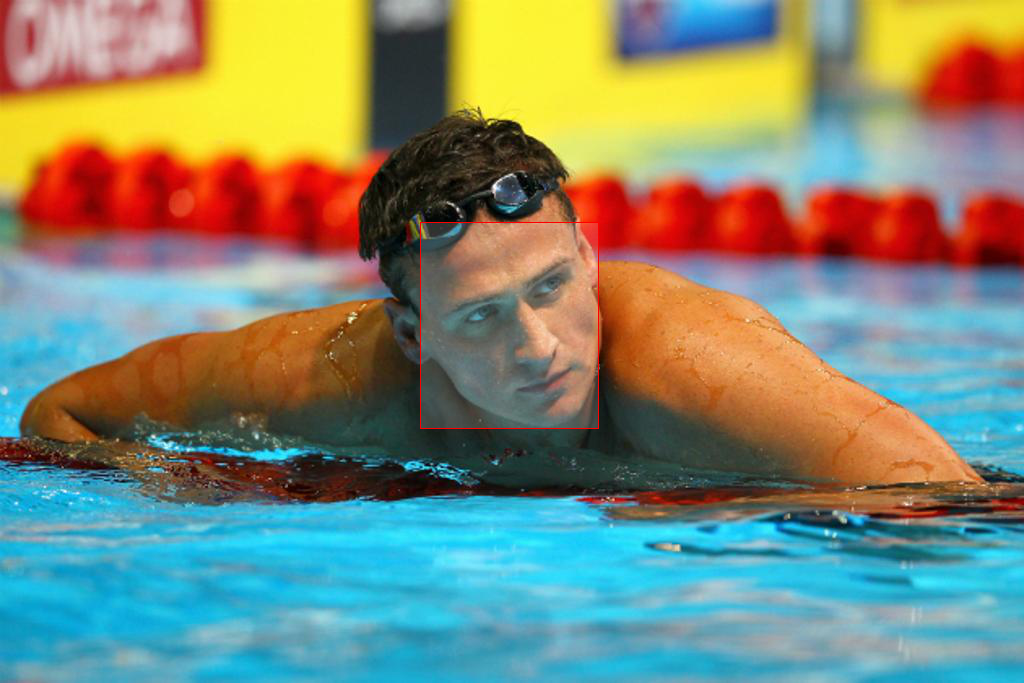

In [10]:
i = random.randint(0, len(metadata) - 1)  # choose a random image
some_boxes = boxes[metadata.path[i]]
draw_boxes_on_image(metadata.full_path[i], some_boxes)

# Convert

In [11]:
def get_annotation(path, width, height):
    name = path.split('/')[-1]
    annotation = {
      "filename": name,
      "size": {"depth": 3, "width": width, "height": height}
    }
    objects = []
    for b in boxes[path]:
        xmin, ymin, w, h = b
        xmax, ymax = xmin + w, ymin + h
        objects.append({
            "bndbox": {"ymin": ymin, "ymax": ymax, "xmax": xmax, "xmin": xmin}, 
            "name": "face"
        })
    annotation["object"] = objects
    return annotation

In [12]:
# create a folder for the converted dataset
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)
shutil.rmtree(RESULT_DIR, ignore_errors=True)
os.mkdir(RESULT_DIR)
os.mkdir(os.path.join(RESULT_DIR, 'images'))
os.mkdir(os.path.join(RESULT_DIR, 'annotations'))

In [31]:
for T in tqdm(metadata.itertuples()):
    
    # get width and height of an image
    image = cv2.imread(T.full_path)
    h, w, c = image.shape
    assert c == 3
    
    # name of the image
    name = T.path.split('/')[-1]
    assert name.endswith('.jpg')

    # copy the image
    shutil.copy(T.full_path, os.path.join(RESULT_DIR, 'images', name))
    
    # save annotation for it
    d = get_annotation(T.path, w, h)
    json_name = name[:-4] + '.json'
    json.dump(d, open(os.path.join(RESULT_DIR, 'annotations', json_name), 'w')) 

0it [00:00, ?it/s]

2it [00:00, 16.27it/s]

3it [00:00, 12.61it/s]

6it [00:00, 17.64it/s]

15it [00:00, 33.69it/s]

30it [00:00, 54.94it/s]

39it [00:00, 60.29it/s]

54it [00:00, 69.98it/s]

67it [00:00, 74.19it/s]

79it [00:01, 78.38it/s]

90it [00:01, 80.43it/s]

100it [00:01, 81.05it/s]

112it [00:01, 83.40it/s]

125it [00:01, 86.37it/s]

136it [00:01, 77.95it/s]

145it [00:01, 78.42it/s]

154it [00:01, 77.39it/s]

162it [00:02, 76.74it/s]

170it [00:02, 76.39it/s]

178it [00:02, 74.24it/s]

190it [00:02, 75.77it/s]

198it [00:02, 75.50it/s]

206it [00:02, 74.66it/s]

214it [00:02, 73.00it/s]

221it [00:03, 71.27it/s]

228it [00:03, 69.97it/s]

234it [00:03, 68.51it/s]

245it [00:03, 69.52it/s]

252it [00:03, 68.35it/s]

258it [00:03, 65.95it/s]

263it [00:04, 65.18it/s]

268it [00:04, 64.05it/s]

273it [00:04, 63.34it/s]

282it [00:04, 63.73it/s]

297it [00:04, 65.61it/s]

306it [00:04, 65.47it/s]

314it [00:04, 65.77it/s]

328it [00:04, 67.20it/s]

343it [00:04, 68.84it/s]

354it [00:05, 68.85it/s]

364it [00:05, 63.99it/s]

377it [00:05, 64.70it/s]

385it [00:06, 64.13it/s]

397it [00:06, 65.03it/s]

406it [00:06, 64.59it/s]

419it [00:06, 65.61it/s]

429it [00:06, 66.02it/s]

441it [00:06, 66.68it/s]

451it [00:06, 66.14it/s]

462it [00:06, 66.50it/s]

471it [00:07, 66.34it/s]

480it [00:07, 66.62it/s]

492it [00:07, 67.33it/s]

501it [00:07, 67.61it/s]

515it [00:07, 68.40it/s]

527it [00:07, 68.97it/s]

538it [00:07, 69.42it/s]

549it [00:07, 69.70it/s]

559it [00:08, 69.35it/s]

568it [00:08, 69.49it/s]

583it [00:08, 70.08it/s]

600it [00:08, 71.20it/s]

612it [00:08, 71.76it/s]

626it [00:08, 72.54it/s]

638it [00:08, 72.92it/s]

650it [00:08, 73.42it/s]

663it [00:08, 73.96it/s]

675it [00:09, 74.43it/s]

687it [00:09, 73.35it/s]

697it [00:09, 73.50it/s]

709it [00:09, 73.94it/s]

720it [00:09, 74.22it/s]

730it [00:09, 73.73it/s]

742it [00:10, 74.14it/s]

754it [00:10, 74.53it/s]

764it [00:10, 72.35it/s]

777it [00:10, 72.85it/s]

787it [00:10, 73.08it/s]

798it [00:10, 73.32it/s]

809it [00:10, 73.65it/s]

819it [00:11, 73.83it/s]

829it [00:11, 73.95it/s]

839it [00:11, 73.84it/s]

850it [00:11, 74.13it/s]

862it [00:11, 74.42it/s]

872it [00:11, 74.30it/s]

881it [00:11, 73.97it/s]

889it [00:12, 73.75it/s]

899it [00:12, 73.94it/s]

907it [00:12, 73.46it/s]

914it [00:12, 73.32it/s]

921it [00:12, 73.05it/s]

927it [00:12, 72.93it/s]

936it [00:12, 72.80it/s]

945it [00:12, 72.90it/s]

953it [00:13, 72.79it/s]

960it [00:13, 72.57it/s]

970it [00:13, 72.76it/s]

978it [00:13, 72.22it/s]

985it [00:13, 72.14it/s]

992it [00:13, 71.55it/s]

998it [00:14, 71.23it/s]

1005it [00:14, 71.15it/s]

1011it [00:14, 70.24it/s]

1016it [00:14, 69.87it/s]

1021it [00:14, 69.74it/s]

1028it [00:14, 69.67it/s]

1036it [00:14, 69.73it/s]

1042it [00:14, 69.56it/s]

1048it [00:15, 69.43it/s]

1054it [00:15, 69.28it/s]

1060it [00:15, 66.73it/s]

1068it [00:15, 66.79it/s]

1080it [00:16, 67.12it/s]

1088it [00:16, 67.06it/s]

1095it [00:16, 67.04it/s]

1105it [00:16, 67.06it/s]

1112it [00:16, 66.96it/s]

1119it [00:16, 66.89it/s]

1126it [00:16, 66.55it/s]

1132it [00:17, 66.41it/s]

1143it [00:17, 66.64it/s]

1151it [00:17, 66.69it/s]

1161it [00:17, 66.87it/s]

1169it [00:17, 66.63it/s]

1176it [00:17, 66.61it/s]

1183it [00:17, 66.62it/s]

1192it [00:17, 66.73it/s]

1200it [00:17, 66.70it/s]

1207it [00:18, 66.70it/s]

1214it [00:18, 66.38it/s]

1221it [00:18, 66.37it/s]

1228it [00:18, 65.95it/s]

1237it [00:18, 66.04it/s]

1244it [00:18, 65.99it/s]

1253it [00:18, 66.09it/s]

1260it [00:19, 65.64it/s]

1266it [00:19, 65.31it/s]

1276it [00:19, 65.02it/s]

1281it [00:19, 64.52it/s]

1292it [00:19, 64.74it/s]

1299it [00:20, 64.44it/s]

1305it [00:20, 64.16it/s]

1310it [00:20, 64.05it/s]

1316it [00:20, 63.96it/s]

1321it [00:20, 63.89it/s]

1326it [00:21, 62.58it/s]

1330it [00:21, 62.44it/s]

1338it [00:21, 62.50it/s]

1346it [00:21, 62.54it/s]

1355it [00:21, 62.66it/s]

1362it [00:21, 62.67it/s]

1370it [00:21, 62.72it/s]

1377it [00:21, 62.71it/s]

1384it [00:22, 62.66it/s]

1392it [00:22, 62.73it/s]

1401it [00:22, 62.74it/s]

1408it [00:22, 62.62it/s]

1415it [00:22, 62.65it/s]

1423it [00:22, 62.70it/s]

1430it [00:22, 62.55it/s]

1439it [00:22, 62.64it/s]

1448it [00:23, 62.75it/s]

1457it [00:23, 62.84it/s]

1465it [00:23, 62.84it/s]

1475it [00:23, 62.98it/s]

1483it [00:23, 61.98it/s]

1489it [00:24, 61.60it/s]

1499it [00:24, 61.71it/s]

1510it [00:24, 61.90it/s]

1519it [00:24, 62.01it/s]

1527it [00:24, 62.04it/s]

1535it [00:24, 61.99it/s]

1544it [00:24, 62.06it/s]

1552it [00:24, 62.12it/s]

1564it [00:25, 62.32it/s]

1575it [00:25, 62.44it/s]

1584it [00:25, 62.34it/s]

1592it [00:25, 62.38it/s]

1605it [00:25, 62.63it/s]

1614it [00:25, 62.67it/s]

1623it [00:26, 61.95it/s]

1633it [00:26, 62.09it/s]

1641it [00:26, 62.15it/s]

1650it [00:26, 62.25it/s]

1658it [00:26, 62.26it/s]

1668it [00:26, 62.35it/s]

1681it [00:26, 62.56it/s]

1694it [00:26, 62.78it/s]

1704it [00:27, 62.83it/s]

1717it [00:27, 63.07it/s]

1728it [00:27, 63.24it/s]

1739it [00:27, 63.38it/s]

1750it [00:27, 63.44it/s]

1760it [00:27, 63.01it/s]

1772it [00:28, 63.21it/s]

1784it [00:28, 63.34it/s]

1799it [00:28, 63.65it/s]

1810it [00:28, 63.79it/s]

1821it [00:28, 63.85it/s]

1831it [00:28, 63.96it/s]

1841it [00:28, 63.97it/s]

1856it [00:28, 64.27it/s]

1867it [00:29, 64.28it/s]

1877it [00:29, 64.34it/s]

1886it [00:29, 64.39it/s]

1896it [00:29, 64.51it/s]

1905it [00:29, 64.48it/s]

1914it [00:29, 64.05it/s]

1923it [00:29, 64.13it/s]

1932it [00:30, 64.20it/s]

1943it [00:30, 64.34it/s]

1952it [00:30, 64.42it/s]

1961it [00:30, 64.49it/s]

1970it [00:30, 64.57it/s]

1981it [00:30, 64.71it/s]

1992it [00:30, 64.85it/s]

2003it [00:30, 64.99it/s]

2013it [00:30, 65.06it/s]

2023it [00:31, 65.16it/s]

2036it [00:31, 65.35it/s]

2047it [00:31, 65.38it/s]

2057it [00:31, 65.36it/s]

2066it [00:31, 65.18it/s]

2074it [00:31, 65.17it/s]

2083it [00:31, 65.22it/s]

2091it [00:32, 65.23it/s]

2100it [00:32, 65.30it/s]

2108it [00:32, 65.34it/s]

2119it [00:32, 65.46it/s]

2131it [00:32, 65.59it/s]

2149it [00:32, 65.84it/s]

2159it [00:32, 65.94it/s]

2175it [00:32, 66.22it/s]

2189it [00:32, 66.42it/s]

2201it [00:33, 66.39it/s]

2212it [00:33, 66.50it/s]

2225it [00:33, 66.69it/s]

2236it [00:33, 66.67it/s]

2248it [00:33, 66.82it/s]

2259it [00:33, 66.80it/s]

2269it [00:33, 66.87it/s]

2278it [00:34, 66.87it/s]

2288it [00:34, 66.93it/s]

2299it [00:34, 66.99it/s]

2309it [00:34, 67.08it/s]

2322it [00:34, 67.25it/s]

2332it [00:34, 66.71it/s]

2344it [00:35, 66.85it/s]

2353it [00:35, 66.91it/s]

2362it [00:35, 66.91it/s]

2378it [00:35, 67.17it/s]

2389it [00:35, 67.19it/s]

2399it [00:35, 67.25it/s]

2409it [00:35, 67.33it/s]

2419it [00:35, 67.40it/s]

2434it [00:36, 67.59it/s]

2445it [00:36, 67.68it/s]

2456it [00:36, 67.79it/s]

2467it [00:36, 67.83it/s]

2480it [00:36, 67.99it/s]

2491it [00:36, 67.98it/s]

2504it [00:36, 68.11it/s]

2522it [00:36, 68.41it/s]

2535it [00:37, 68.51it/s]

2547it [00:37, 68.59it/s]

2558it [00:37, 68.58it/s]

2568it [00:37, 68.55it/s]

2577it [00:37, 68.40it/s]

2585it [00:37, 68.31it/s]

2595it [00:37, 68.39it/s]

2609it [00:38, 68.52it/s]

2618it [00:38, 68.53it/s]

2627it [00:38, 68.55it/s]

2635it [00:38, 68.53it/s]

2643it [00:38, 68.40it/s]

2650it [00:38, 68.35it/s]

2661it [00:38, 68.45it/s]

2669it [00:38, 68.46it/s]

2677it [00:39, 68.46it/s]

2686it [00:39, 68.47it/s]

2695it [00:39, 68.40it/s]

2708it [00:39, 68.54it/s]

2717it [00:40, 67.81it/s]

2734it [00:40, 68.06it/s]

2750it [00:40, 68.29it/s]

2763it [00:40, 68.41it/s]

2776it [00:40, 68.53it/s]

2789it [00:40, 68.68it/s]

2801it [00:40, 68.78it/s]

2813it [00:40, 68.83it/s]

2824it [00:40, 68.92it/s]

2836it [00:41, 69.03it/s]

2850it [00:41, 69.19it/s]

2862it [00:41, 69.19it/s]

2872it [00:41, 69.21it/s]

2882it [00:41, 69.21it/s]

2891it [00:41, 69.18it/s]

2899it [00:41, 69.18it/s]

2907it [00:42, 69.18it/s]

2915it [00:42, 69.18it/s]

2923it [00:42, 69.19it/s]

2935it [00:42, 69.28it/s]

2944it [00:42, 69.22it/s]

2952it [00:42, 69.23it/s]

2960it [00:43, 68.66it/s]

2966it [00:43, 68.62it/s]

2973it [00:43, 68.60it/s]

2979it [00:43, 68.57it/s]

2986it [00:43, 68.54it/s]

2992it [00:43, 68.47it/s]

3001it [00:43, 68.51it/s]

3008it [00:43, 68.42it/s]

3018it [00:44, 68.48it/s]

3025it [00:44, 68.38it/s]

3032it [00:44, 68.28it/s]

3038it [00:44, 68.03it/s]

3047it [00:44, 68.08it/s]

3053it [00:44, 68.05it/s]

3062it [00:44, 68.10it/s]

3069it [00:45, 67.99it/s]

3078it [00:45, 67.99it/s]

3087it [00:45, 68.01it/s]

3094it [00:45, 67.98it/s]

3104it [00:45, 68.04it/s]

3112it [00:45, 67.99it/s]

3122it [00:45, 68.02it/s]

3130it [00:46, 68.04it/s]

3138it [00:46, 67.98it/s]

3145it [00:46, 67.92it/s]

3155it [00:46, 67.98it/s]

3165it [00:46, 68.04it/s]

3176it [00:46, 68.13it/s]

3185it [00:46, 68.06it/s]

3193it [00:46, 67.98it/s]

3200it [00:47, 67.89it/s]

3210it [00:47, 67.96it/s]

3218it [00:47, 67.94it/s]

3228it [00:47, 67.97it/s]

3240it [00:47, 68.08it/s]

3250it [00:47, 68.12it/s]

3259it [00:48, 67.86it/s]

3268it [00:48, 67.88it/s]

3276it [00:48, 67.89it/s]

3285it [00:48, 67.93it/s]

3293it [00:48, 67.84it/s]

3304it [00:48, 67.93it/s]

3314it [00:48, 67.98it/s]

3323it [00:48, 67.98it/s]

3337it [00:48, 68.13it/s]

3354it [00:49, 68.33it/s]

3366it [00:49, 68.34it/s]

3378it [00:49, 68.42it/s]

3389it [00:49, 68.46it/s]

3403it [00:49, 68.60it/s]

3414it [00:49, 68.59it/s]

3424it [00:49, 68.65it/s]

3434it [00:49, 68.69it/s]

3444it [00:50, 68.72it/s]

3453it [00:50, 68.71it/s]

3462it [00:50, 68.69it/s]

3470it [00:50, 68.62it/s]

3479it [00:50, 68.66it/s]

3487it [00:50, 68.57it/s]

3494it [00:50, 68.54it/s]

3501it [00:51, 68.45it/s]

3512it [00:51, 68.53it/s]

3525it [00:51, 68.65it/s]

3540it [00:51, 68.75it/s]

3550it [00:51, 68.77it/s]

3562it [00:51, 68.81it/s]

3571it [00:51, 68.83it/s]

3581it [00:52, 68.83it/s]

3590it [00:52, 68.83it/s]

3599it [00:52, 68.85it/s]

3608it [00:52, 68.88it/s]

3616it [00:52, 68.90it/s]

3624it [00:52, 68.90it/s]

3632it [00:53, 68.48it/s]

3638it [00:53, 68.42it/s]

3647it [00:53, 68.38it/s]

3655it [00:53, 68.40it/s]

3663it [00:53, 68.42it/s]

3672it [00:53, 68.45it/s]

3682it [00:53, 68.51it/s]

3694it [00:53, 68.58it/s]

3703it [00:53, 68.58it/s]

3712it [00:54, 68.59it/s]

3721it [00:54, 68.61it/s]

3732it [00:54, 68.66it/s]

3747it [00:54, 68.77it/s]

3757it [00:54, 68.79it/s]

3766it [00:54, 68.76it/s]

3774it [00:54, 68.73it/s]

3786it [00:55, 68.82it/s]

3795it [00:55, 68.84it/s]

3805it [00:55, 68.89it/s]

3815it [00:55, 68.95it/s]

3825it [00:55, 68.89it/s]

3834it [00:55, 68.90it/s]

3844it [00:55, 68.93it/s]

3852it [00:55, 68.93it/s]

3860it [00:55, 68.95it/s]

3871it [00:56, 69.02it/s]

3880it [00:56, 68.98it/s]

3889it [00:56, 69.01it/s]

3897it [00:56, 68.94it/s]

3904it [00:56, 68.80it/s]

3914it [00:56, 68.85it/s]

3923it [00:57, 68.77it/s]

3930it [00:57, 68.75it/s]

3938it [00:57, 68.72it/s]

3944it [00:57, 68.61it/s]

3955it [00:57, 68.67it/s]

3962it [00:58, 68.14it/s]

3969it [00:58, 68.14it/s]

3981it [00:58, 68.22it/s]

3992it [00:58, 68.28it/s]

4011it [00:58, 68.49it/s]

4023it [00:58, 68.57it/s]

4045it [00:58, 68.81it/s]

4059it [00:58, 68.82it/s]

4072it [00:59, 68.92it/s]

4093it [00:59, 69.16it/s]

4108it [00:59, 69.26it/s]

4122it [00:59, 69.22it/s]

4134it [00:59, 69.21it/s]

4144it [00:59, 69.21it/s]

4156it [00:59, 69.29it/s]

4168it [01:00, 69.37it/s]

4183it [01:00, 69.50it/s]

4195it [01:00, 69.58it/s]

4207it [01:00, 69.62it/s]

4221it [01:00, 69.72it/s]

4233it [01:00, 69.74it/s]

4244it [01:00, 69.80it/s]

4257it [01:00, 69.89it/s]

4271it [01:01, 70.00it/s]

4284it [01:01, 70.09it/s]

4296it [01:01, 70.15it/s]

4308it [01:01, 70.19it/s]

4319it [01:01, 70.20it/s]

4329it [01:01, 70.23it/s]

4341it [01:01, 70.29it/s]

4354it [01:01, 70.36it/s]

4364it [01:02, 70.38it/s]

4374it [01:02, 70.42it/s]

4384it [01:02, 70.42it/s]

4393it [01:02, 70.44it/s]

4403it [01:02, 70.48it/s]

4417it [01:02, 70.58it/s]

4428it [01:02, 70.55it/s]

4437it [01:03, 70.21it/s]

4444it [01:03, 70.19it/s]

4455it [01:03, 70.21it/s]

4464it [01:03, 70.24it/s]

4476it [01:03, 70.31it/s]

4487it [01:03, 70.37it/s]

4498it [01:03, 70.42it/s]

4508it [01:04, 70.38it/s]

4517it [01:04, 70.12it/s]

4524it [01:04, 70.11it/s]

4536it [01:04, 70.19it/s]

4552it [01:04, 70.32it/s]

4563it [01:04, 70.38it/s]

4581it [01:04, 70.52it/s]

4593it [01:05, 70.57it/s]

4604it [01:05, 70.59it/s]

4615it [01:05, 70.64it/s]

4625it [01:05, 70.64it/s]

4637it [01:05, 70.70it/s]

4648it [01:05, 70.72it/s]

4658it [01:05, 70.63it/s]

4666it [01:06, 70.56it/s]

4677it [01:06, 70.61it/s]

4688it [01:06, 70.66it/s]

4697it [01:06, 70.67it/s]

4706it [01:06, 70.65it/s]

4716it [01:06, 70.70it/s]

4725it [01:06, 70.71it/s]

4734it [01:06, 70.70it/s]

4742it [01:07, 70.66it/s]

4752it [01:07, 70.68it/s]

4760it [01:07, 70.59it/s]

4767it [01:07, 70.47it/s]

4773it [01:07, 70.44it/s]

4779it [01:08, 70.00it/s]

4785it [01:08, 69.98it/s]

4792it [01:08, 69.98it/s]

4803it [01:08, 70.03it/s]

4810it [01:08, 70.02it/s]

4817it [01:08, 70.00it/s]

4824it [01:08, 69.98it/s]

4833it [01:09, 70.01it/s]

4841it [01:09, 70.01it/s]

4849it [01:09, 69.87it/s]

4856it [01:09, 69.87it/s]

4863it [01:09, 69.85it/s]

4870it [01:09, 69.84it/s]

4877it [01:09, 69.82it/s]

4884it [01:10, 69.75it/s]

4893it [01:10, 69.77it/s]

4900it [01:10, 69.60it/s]

4908it [01:10, 69.61it/s]

4915it [01:10, 69.59it/s]

4925it [01:10, 69.63it/s]

4932it [01:10, 69.56it/s]

4939it [01:11, 69.50it/s]

4946it [01:11, 69.49it/s]

4955it [01:11, 69.50it/s]

4962it [01:11, 69.44it/s]

4968it [01:11, 69.37it/s]

4974it [01:11, 69.31it/s]

4983it [01:11, 69.31it/s]

4989it [01:12, 69.26it/s]

4998it [01:12, 69.27it/s]

5004it [01:12, 69.07it/s]

5014it [01:12, 69.11it/s]

5021it [01:12, 69.04it/s]

5027it [01:13, 68.66it/s]

5033it [01:13, 68.64it/s]

5042it [01:13, 68.67it/s]

5048it [01:13, 68.58it/s]

5054it [01:13, 68.56it/s]

5063it [01:13, 68.58it/s]

5072it [01:13, 68.61it/s]

5080it [01:14, 68.61it/s]

5087it [01:14, 68.61it/s]

5094it [01:14, 68.61it/s]

5104it [01:14, 68.63it/s]

5112it [01:14, 68.62it/s]

5120it [01:14, 68.62it/s]

5127it [01:14, 68.55it/s]

5134it [01:14, 68.47it/s]

5140it [01:15, 68.39it/s]

5148it [01:15, 68.40it/s]

5155it [01:15, 68.40it/s]

5161it [01:15, 68.33it/s]

5168it [01:15, 68.33it/s]

5175it [01:15, 68.33it/s]

5182it [01:15, 68.27it/s]

5188it [01:16, 68.19it/s]

5193it [01:16, 68.14it/s]

5198it [01:16, 68.07it/s]

5206it [01:16, 68.06it/s]

5211it [01:16, 68.03it/s]

5217it [01:16, 68.01it/s]

5223it [01:16, 67.98it/s]

5231it [01:16, 67.99it/s]

5237it [01:17, 67.91it/s]

5243it [01:17, 67.85it/s]

5248it [01:17, 67.82it/s]

5253it [01:17, 67.70it/s]

5257it [01:17, 67.64it/s]

5262it [01:18, 67.27it/s]

5265it [01:18, 67.19it/s]

5268it [01:18, 67.10it/s]

5276it [01:18, 67.10it/s]

5280it [01:18, 67.04it/s]

5284it [01:18, 66.96it/s]

5292it [01:19, 66.95it/s]

5298it [01:19, 66.93it/s]

5308it [01:19, 66.94it/s]

5317it [01:19, 66.97it/s]

5324it [01:19, 66.97it/s]

5332it [01:19, 66.94it/s]

5339it [01:19, 66.83it/s]

5346it [01:19, 66.83it/s]

5353it [01:20, 66.83it/s]

5360it [01:20, 66.84it/s]

5368it [01:20, 66.85it/s]

5377it [01:20, 66.85it/s]

5384it [01:20, 66.83it/s]

5391it [01:20, 66.81it/s]

5398it [01:21, 66.62it/s]

5406it [01:21, 66.62it/s]

5412it [01:21, 66.57it/s]

5418it [01:21, 66.47it/s]

5423it [01:21, 66.35it/s]

5431it [01:21, 66.36it/s]

5436it [01:21, 66.33it/s]

5442it [01:22, 66.31it/s]

5448it [01:22, 66.30it/s]

5454it [01:22, 66.26it/s]

5462it [01:22, 66.27it/s]

5470it [01:22, 66.28it/s]

5478it [01:22, 66.29it/s]

5486it [01:22, 66.29it/s]

5493it [01:23, 65.87it/s]

5499it [01:23, 65.82it/s]

5504it [01:23, 65.76it/s]

5513it [01:23, 65.79it/s]

5524it [01:23, 65.84it/s]

5532it [01:24, 65.80it/s]

5539it [01:24, 65.79it/s]